# 3. Expérimentation et comparaison des architectures RNN

### Import des bibliothèques

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

Sequential = tf.keras.models.Sequential
SimpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Bidirectional = tf.keras.layers.Bidirectional
EarlyStopping = tf.keras.callbacks.EarlyStopping
Adam = tf.keras.optimizers.Adam


### Création du titre des images

In [2]:
import unicodedata

def titre_to_filename(titre, dossier ="figures",suffix=""):
    titre = unicodedata.normalize('NFKD', titre).encode('ASCII', 'ignore').decode()
    titre = re.sub(r'[^a-zA-Z0-9]', '_', titre)
    titre = re.sub(r'_+', '_', titre).strip('_')

    if suffix:
        titre += f"__{suffix}"

    racine_projet = os.path.abspath(os.path.join(os.getcwd(), ".."))
    chemin_figures = os.path.join(racine_projet, dossier)
    os.makedirs(chemin_figures, exist_ok=True)

    return os.path.join(chemin_figures, titre + ".png")

### Récuperer les paramètres pour dinstinguer les images

In [3]:
def get_param_suffix():
    return f"WS{WINDOW_SIZE}_U{UNITS}_DO{int(DROPOUT*100)}_" \
           f"{'STACKED' if STACKED else 'SINGLE'}_" \
           f"{'BIDIR' if USE_BIDIRECTIONAL else 'UNIDIR'}"

### Chargement des données prétraitées

In [4]:
def load_dataset(path):
    df = pd.read_csv(path, header=None)
    data = df.values
    X = data[:, :-1]
    y = data[:, -1]
    return X[..., np.newaxis], y

X_train, y_train = load_dataset("../data/TrainDataSet.csv")
X_val, y_val = load_dataset("../data/ValidationDataSet.csv")
X_test, y_test = load_dataset("../data/TestDataSet.csv")

### Construction du modèle

In [5]:
def build_model(rnn_type="SimpleRNN"):
    model = Sequential()
    rnn_layer = None

    # Choix du type de couche RNN
    if rnn_type == "SimpleRNN":
        rnn_layer = SimpleRNN(UNITS, return_sequences=STACKED or USE_BIDIRECTIONAL, input_shape=(WINDOW_SIZE, 1))
    elif rnn_type == "LSTM":
        rnn_layer = LSTM(UNITS, return_sequences=STACKED or USE_BIDIRECTIONAL, input_shape=(WINDOW_SIZE, 1))
    elif rnn_type == "GRU":
        rnn_layer = GRU(UNITS, return_sequences=STACKED or USE_BIDIRECTIONAL, input_shape=(WINDOW_SIZE, 1))

    # Enveloppe Bidirectionnelle si activée
    if USE_BIDIRECTIONAL:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    # Deuxième couche RNN si empilement activé
    if STACKED:
        if rnn_type == "SimpleRNN":
            model.add(SimpleRNN(UNITS))
        elif rnn_type == "LSTM":
            model.add(LSTM(UNITS))
        elif rnn_type == "GRU":
            model.add(GRU(UNITS))

    # Couche de sortie
    model.add(Dropout(DROPOUT))
    model.add(Dense(1))
    return model

### Compilation et Entraînement

In [6]:
def compile_and_train(model, X_train, y_train, X_val, y_val):
    model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Affichage de la courbe d'apprentissage
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Courbe de perte - {model.name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    suffix = get_param_suffix()
    filename = titre_to_filename(f"Courbe de perte - {model.name}", dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return model

### Évaluation du modèle

In [7]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Visualisation des prédictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label='Réel')
    plt.plot(y_pred, label='Prédit')
    plt.title(f"Réel vs Prédit - {name}")
    plt.legend()
    plt.grid(True)
    suffix = get_param_suffix()
    filename = titre_to_filename(f"Réel vs Prédit - {name}", dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return {"Modèle": name, "MSE": mse, "MAE": mae, "RMSE": rmse}

### Boucle principale d'expérimentation

In [8]:
def train_and_evaluate_all_models():
    results = []
    trained_models = {}

    for rnn_type in ["SimpleRNN", "LSTM", "GRU"]:
        print(f"\n===== Entraînement du modèle : {rnn_type} =====")
        model = build_model(rnn_type)
        model.name = rnn_type
        model = compile_and_train(model, X_train, y_train, X_val, y_val)

        metrics = evaluate_model(model, X_test, y_test, rnn_type)
        results.append(metrics)
        trained_models[rnn_type] = model

    return results, trained_models



### Tableau comparatif final

In [9]:
def afficher_comparaison_des_performances(results):
    results_df = pd.DataFrame(results)
    print("\nComparaison des performances :")
    print(results_df)


### Visualisation comparée des prédictions

In [10]:
def afficher_predictions_detaillees(trained_models,N=100):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test[:N], label="Valeurs réelles", linewidth=2)

    for name, model in trained_models.items():
        y_pred = model.predict(X_test)
        plt.plot(y_pred[:N], label=f"Prédictions {name}")

    titre = "Comparaison des prédictions vs réel (extrait)"
    plt.title(titre)
    plt.xlabel("Temps")
    plt.ylabel("Température (normalisée)")
    plt.legend()
    plt.grid(True)

    suffix = get_param_suffix()
    filename = titre_to_filename(titre, dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



### Experimentation avec paramètres basiques


===== Entraînement du modèle : SimpleRNN =====


c:\Users\loris\MASI4-git\FrameworksMachineLearning\frameworks-machine-learning-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


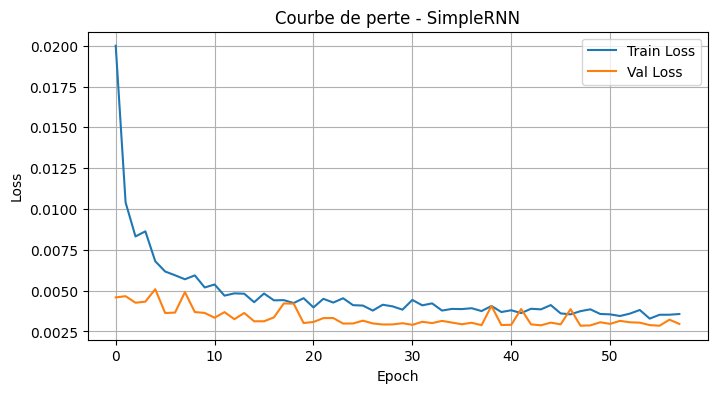

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SimpleRNN - MSE: 0.0020, MAE: 0.0348, RMSE: 0.0448


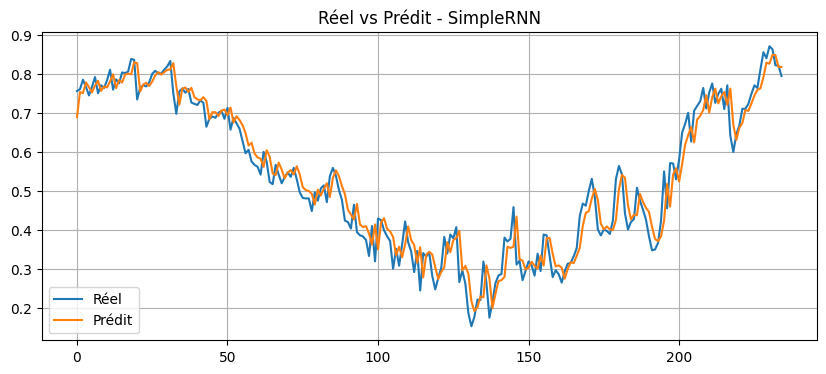


===== Entraînement du modèle : LSTM =====


c:\Users\loris\MASI4-git\FrameworksMachineLearning\frameworks-machine-learning-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


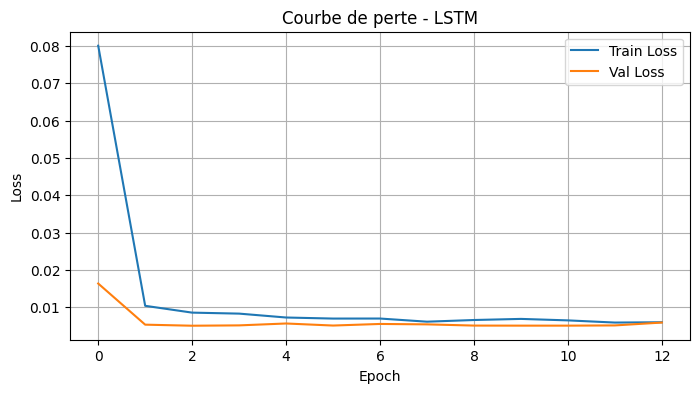

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM - MSE: 0.0047, MAE: 0.0561, RMSE: 0.0687


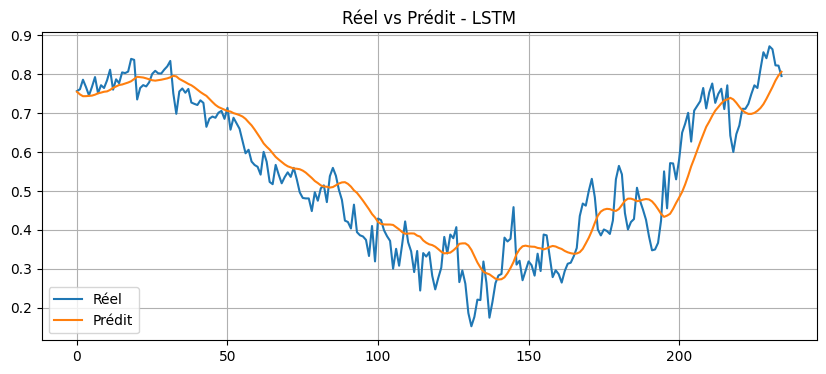


===== Entraînement du modèle : GRU =====


c:\Users\loris\MASI4-git\FrameworksMachineLearning\frameworks-machine-learning-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


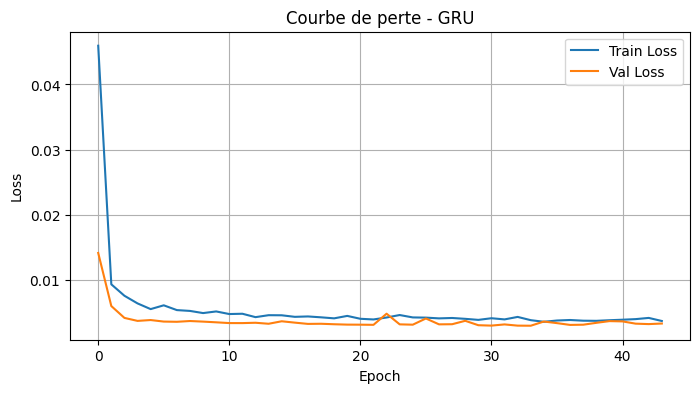

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
GRU - MSE: 0.0020, MAE: 0.0355, RMSE: 0.0449


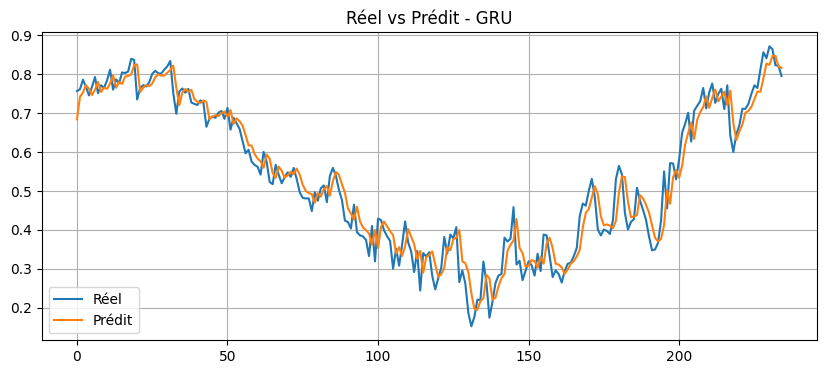

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


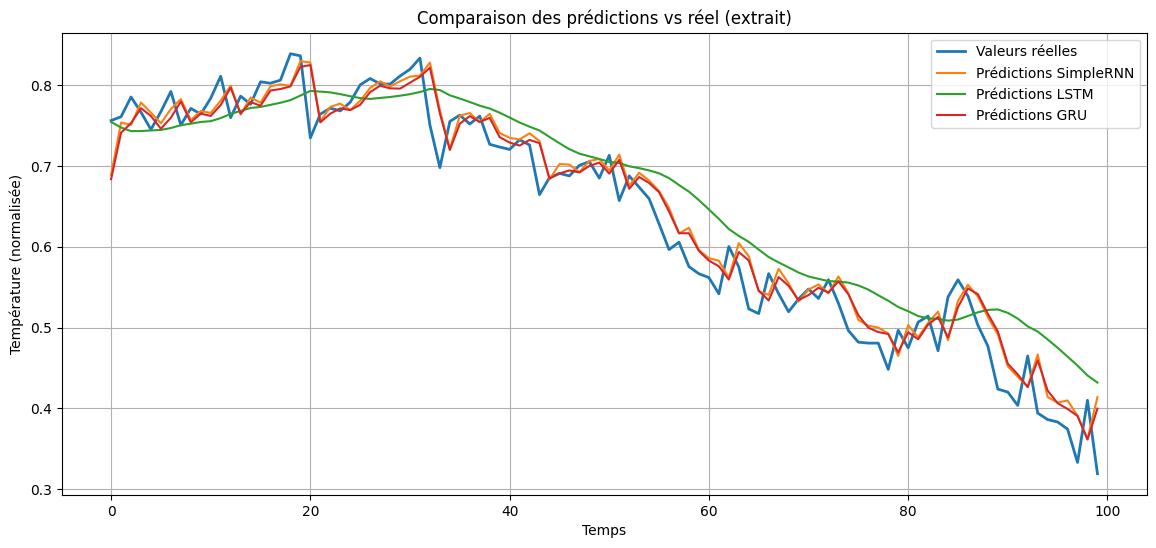


Comparaison des performances :
      Modèle       MSE       MAE      RMSE
0  SimpleRNN  0.002003  0.034843  0.044756
1       LSTM  0.004717  0.056111  0.068678
2        GRU  0.002017  0.035452  0.044909


In [ ]:
WINDOW_SIZE = 14
UNITS = 64
DROPOUT = 0.2
STACKED = False         
USE_BIDIRECTIONAL = False  

results, trained_models = train_and_evaluate_all_models()

afficher_predictions_detaillees(trained_models=trained_models)

afficher_comparaison_des_performances(results)


**Dernier Notebook : Evaluation et analyse**

👉 [Aller au dernier Notebook](05_evaluation_et_analyse.ipynb)